In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt

## Ⅰ. 역전파

<img src="../img/5-6.PNG" width="30%" height="30%"/>

### 1. 덧셈 노드의 역전파

$$
z = x + y
$$

$$
\frac{\partial z}{\partial x} = 1 \quad
\frac{\partial z}{\partial y} = 1
$$


<img src="../img/5-9.PNG" width="50%" height="50%"/>

In [2]:
class AddLayer:
    
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx, dy = dout, dout
        return dx, dy

### 2. 곱셈 노드의 역전파

$$
z =xy
$$

$$
\frac{\partial z}{\partial x} = y 
\quad
\frac{\partial z}{\partial y} = x
$$

<img src="../img/5-12.PNG" width="50%" height="50%"/>

In [3]:
class MulLayer:
    
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x , self.y = x, y
        out = x * y
        return out
    
    def backward(self, dout):
        dx, dy = self.y * dout, self.x * dout
        return dx, dy

### 3. 예시

<img src="../img/fig 5-17.png" width="50%" height="50%"/>

In [4]:
class Example:

    def __init__(self):
        self.mul_apple_layer = MulLayer()
        self.mul_orange_layer = MulLayer()
        self.add_fruit_layer = AddLayer()
        self.mul_tax_layer = MulLayer()
        
    def forward(self, apple_num, apple_price, orange_num, orange_price, tax):
        apple_tot_price = self.mul_apple_layer.forward(apple_num, apple_price)
        orange_tot_price = self.mul_orange_layer.forward(orange_num, orange_price)
        fruit_tot_price = self.add_fruit_layer.forward(apple_tot_price, orange_tot_price)
        tot_price = self.mul_tax_layer.forward(fruit_tot_price, tax)
        return tot_price
    
    def backward(self):
        dtot_price = 1
        dfruit_tot_price, dtax = self.mul_tax_layer.backward(dtot_price)
        dapple_tot_price, dorange_tot_price = self.add_fruit_layer.backward(dfruit_tot_price)
        dorange_num, dorange_price = self.mul_orange_layer.backward(dorange_tot_price)
        dapple_num, dapple_price = self.mul_apple_layer.backward(dapple_tot_price)
        return dapple_num, dapple_price, dorange_num, dorange_price, dtax

ex = Example()

params = {'apple_num':2, 'apple_price':100, 'orange_num':3, 'orange_price':150, 'tax':1.1}
print('forward : \n\t tot_price =', ex.forward(**params))
print('backward :')
for key, val in zip(params, ex.backward()):
    print('\t',key, ':', val)

forward : 
	 tot_price = 715.0000000000001
backward :
	 apple_num : 110.00000000000001
	 apple_price : 2.2
	 orange_num : 165.0
	 orange_price : 3.3000000000000003
	 tax : 650


## Ⅱ. 신경망 함수의 역전파

### 1. Affine

$$
 \mathbf{Y} = \mathbf{X} \cdot \mathbf{W} + \mathbf{B}
$$
  
<img src="../img/fig 5-27.png" width="50%" height="50%"/>

In [5]:
class Affine:

    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        return dx

### 2. ReLU

$$
 y = \begin{cases}
 x & (x>0)\\
 0 & (x<=0)
 \end{cases}
$$

$$
 \frac{\partial y}{\partial x} = \begin{cases}
 1 & (x>0)\\
 0 & (x<=0)
 \end{cases}
$$

In [6]:
class ReLU:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        return dout

### 3. Sigmoid

$$
 y = \frac{1}{1 + \text{exp}(-x)}
$$

$$
 \frac{\partial y}{\partial x} = y(1-y)
$$

In [7]:
class Sigmoid:

    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

### Softmax with Loss

<img src='../img/fig 5-30.png' width=50% height=50%/>

In [8]:
from common.functions import softmax, cross_entropy_error

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

## Ⅲ. 수치 미분과의 비교

In [9]:
from common.gradient import numerical_gradient
from collections import OrderedDict

In [10]:
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['ReLU1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        loss = self.loss(x, t)
        
        dout = 1
        dout = self.lastLayer.backward(dout)
        for layer in reversed(self.layers.values()):
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads, loss

In [11]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [12]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch, t_batch = x_train[:3], t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop, _ = network.gradient(x_batch, t_batch)

for key in grad_numerical:
    diff = np.mean(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(f'{key} : {diff}')

W1 : 4.899409381026737e-10
b1 : 3.0213108757871054e-09
W2 : 6.275960693988544e-09
b2 : 1.3926431820798779e-07


## Ⅳ. MNIST 훈련

In [13]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# hyperparameters
iters_num = 10000
batch_size = 100
learning_rate = 0.1

# cache
train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in range(iters_num):
    batch_mask = np.random.choice(x_train.shape[0], batch_size)
    x_batch, t_batch = x_train[batch_mask], t_train[batch_mask]
    
    grad, loss = network.gradient(x_batch, t_batch)
    for key in grad:
        network.params[key] -= learning_rate * grad[key]
    train_loss_list.append(loss)
    
    if (i+1) % 1000 == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'iteration {i+1:02}/{iters_num}\ttrain accuracy : {train_acc:.4f}\ttest accuracy : {test_acc:.4f}')
    

iteration 1000/10000	train accuracy : 0.9182	test accuracy : 0.9220
iteration 2000/10000	train accuracy : 0.9383	test accuracy : 0.9357
iteration 3000/10000	train accuracy : 0.9496	test accuracy : 0.9465
iteration 4000/10000	train accuracy : 0.9581	test accuracy : 0.9553
iteration 5000/10000	train accuracy : 0.9635	test accuracy : 0.9597
iteration 6000/10000	train accuracy : 0.9677	test accuracy : 0.9605
iteration 7000/10000	train accuracy : 0.9713	test accuracy : 0.9631
iteration 8000/10000	train accuracy : 0.9748	test accuracy : 0.9653
iteration 9000/10000	train accuracy : 0.9760	test accuracy : 0.9662
iteration 10000/10000	train accuracy : 0.9790	test accuracy : 0.9686


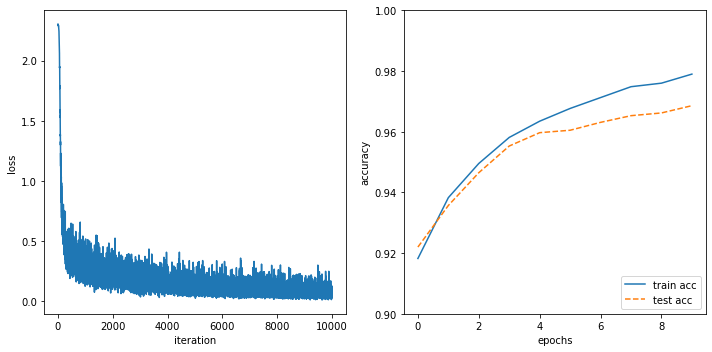

In [14]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

x_loss = np.arange(len(train_loss_list))
ax1.plot(x_loss, train_loss_list)
ax1.set_xlabel("iteration")
ax1.set_ylabel("loss")

x_acc = np.arange(len(train_acc_list))
ax2.plot(x_acc, train_acc_list, label='train acc')
ax2.plot(x_acc, test_acc_list, label='test acc', linestyle='--')
ax2.set_xlabel("epochs")
ax2.set_ylabel("accuracy")
ax2.set_ylim(0.9, 1.0)
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()